# Clean Bibliography

To goal of this notebook is to clean your `.bib` file to ensure that it only contains the full first names of references that you have cited in your paper. The full first names will then be used to query the probabilistic gender classifier, [Gender API](https://gender-api.com) if over 100 names or [genderize.io](https://genderize.io) if under 100 names. The full names will be used to query for probabilistic race using the [ethnicolr package](https://ethnicolr.readthedocs.io/).

The only required file you need is your manuscript's bibliography in `.bib` format. __Your `.bib` must only contain references cited in the manuscript__. Otherwise, the estimated proportions will be inaccurate.

If you intend to analyze the reference list of a published paper instead of your own manuscript in progress, search the paper on [Web of Knowledge](http://apps.webofknowledge.com/) (you will need institutional access). Next, [download the .bib file from Web of Science following these instructions, but start from Step 4 and on Step 6 select BibTeX instead of Plain Text](https://github.com/jdwor/gendercitation/blob/master/Step0_PullingWOSdata.pdf).

If you are not using LaTeX, collect and organize only the references you have cited in your manuscript using your reference manager of choice (e.g. Mendeley, Zotero, EndNote, ReadCube, etc.) and export that selected bibliography as a `.bib` file. __Please try to export your .bib in an output style that uses full first names (rather than only first initials) and using the full author lists (rather than abbreviated author lists with "et al.").__ If first initials are included, our code will automatically retrieve about 70% of those names using the article title or DOI. 

   * [Export `.bib` from Mendeley](https://blog.mendeley.com/2011/10/25/howto-use-mendeley-to-create-citations-using-latex-and-bibtex/)
   * [Export `.bib` from Zotero](https://libguides.mit.edu/ld.php?content_id=34248570)
   * [Export `.bib` from EndNote](https://www.reed.edu/cis/help/LaTeX/EndNote.html). Note: Please export full first names by either [choosing an output style that does so by default (e.g. in MLA style)](https://canterbury.libguides.com/endnote/basics-output) or by [customizing an output style.](http://bibliotek.usn.no/cite-and-write/endnote/how-to-use/how-to-show-the-author-s-full-name-in-the-reference-list-article185897-28181.html)
   * [Export `.bib` from Read Cube Papers](https://support.papersapp.com/support/solutions/articles/30000024634-how-can-i-export-references-from-readcube-papers-)

For those working in LaTeX, we can use an optional `.aux` file to automatically filter your `.bib` to check that it only contains entries which are cited in your manuscript.

| Input                 | Output                                                                                                                        |
|-----------------------|-------------------------------------------------------------------------------------------------------------------------------|
| `.bib` file(s)**(REQUIRED)**    | `cleanBib.csv`: table of author first names, titles, and .bib keys                                                            |
| `.aux` file (OPTIONAL)| `predictions.csv`: table of author first names, estimated gender classification, and confidence                                   |
| `.tex` file (OPTIONAL) | `race_gender_citations.pdf`: heat map of your citations broken down by probabilistic gender and race estimations
|                       | `yourTexFile_gendercolor.tex`: your `.tex` file modified to compile .pdf with in-line citations colored-coded by gender pairs |

## 1. Import functions

Upload your `.bib` file(s) and _optionally_ an `.aux` file generated from compiling your LaTeX manuscript and your `.tex` file

![upload button](img/upload.png)

![confirm upload button](img/confirmUpload.png)

Then, run the code block below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

In [2]:
%load_ext autoreload # automatically reloads modules..not sure we need
%autoreload 2

import glob
from habanero import Crossref
import sys
import os
from pathlib import Path
wd = Path(os.getcwd())
#sys.path.insert(1, f'{wd.absolute()}/utils')
from preprocessing import *
from ethnicolr import pred_fl_reg_name
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

cr = Crossref()
homedir = '' #'/home/jovyan/'
bib_files = glob.glob(homedir + '*.bib')
paper_aux_file = glob.glob(homedir + '*.aux')
paper_bib_file = 'library_paper.bib'
try:
    tex_file = glob.glob(homedir + "*.tex")[0]
except:
    print('No optional .tex file found.')
if len(bib_files) == 0:
    print("No .bib file found.")

2024-09-04 17:55:32.722226: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 17:55:33.241377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 17:55:33.241459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 17:55:33.336256: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 17:55:33.547148: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 17:55:33.549390: I tensorflow/core/platform/cpu_feature_guard.cc:1

No optional .tex file found.


In [4]:
print(bib_files)
print(paper_aux_file)

['final.bib']
['contact.aux', 'supp.aux']


### 2. Define the _first_ and _last_ author of your paper.

For example: 
```
yourFirstAuthor = 'Teich, Erin G.'
yourLastAuthor = 'Bassett, Danielle S.'
```

And optionally, define any co-first or co-last author(s), making sure to keep the square brackets to define a list.

For example:
```
optionalEqualContributors = ['Dworkin, Jordan', 'Stiso, Jennifer']
```

or 

```
optionalEqualContributors = ['Dworkin, Jordan']
```

If you are analyzing published papers' reference lists from Web of Science, change the variable checkingPublishedArticle to True:
```
checkingPublishedArticle = True
```

Then, run the code block below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

__NOTE__: Please edit your .bib file using information printed by the code and provided in cleanedBib.csv. Edit directly within the Binder environment by clicking the .bib file (as shown below), making modifications, and saving the file (as shown below).

![open button](img/openBib.png)

![save button](img/saveBib.png)

Common issues include:

* Bibliography entry did not include a last author because the author list was truncated by "and Others" or "et al."
* Some older journals articles only provide first initial and not full first names, in which case you will need to go digging via Google to identify that person.
* In rare cases where the author cannot be identified even after searching by hand, replace the first name with "UNKNOWNNAMES" so that the classifier will estimate the gender as unknown.
* Make sure groups aren't used as first or last authors

In [6]:
yourFirstAuthor = 'LastName, FirstName OptionalMiddleInitial'
yourLastAuthor = 'LastName, FirstName OptionalMiddleInitial'
optionalEqualContributors = ['LastName, FirstName OptionalMiddleInitial', 'LastName, FirstName OptionalMiddleInitial']
checkingPublishedArticle = False

if paper_aux_file:
    unused_keys = [find_unused_cites([file]) for file in paper_aux_file]
    unused_keys = [item for sublist in unused_keys for item in sublist]
else:
    unused_keys = None


     _           _       _ _
 ___| |_ ___ ___| |_ ___|_| |_ ___ ___
|  _|   | -_|  _| '_|  _| |  _| -_|_ -|
|___|_|_|___|___|_,_|___|_|_| |___|___|

checkcites.lua -- a reference checker script (v2.4)
Copyright (c) 2012, 2019, Enrico Gregorio, Paulo Roberto Massa Cereda

Great, I found 49 citations in 1 file. I also found 1 bibliography file.
Let me check this file and extract the references. Please wait a moment.

Fantastic, I found 6 references in 1 bibliography file. Please wait a
moment while the reports are generated.

--------------------------------------------------------------------------
Report of unused references in your TeX document (that is, references
present in bibliography files, but not cited in the TeX source file)
--------------------------------------------------------------------------

Unused references in your TeX document: 0

--------------------------------------------------------------------------
Report of undefined references in your TeX document (that is, 

### Remove the unused references mentioned above from your .bib file before running the following code chunk

In [8]:
# parses bib file
bib_data = get_bib_data(bib_files[0])
if checkingPublishedArticle:
    get_names_published(homedir, bib_data, cr)
else:
    # find and print duplicates
    bib_data = get_duplicates(bib_data, bib_files[0])
    # get names, remove CDS, find self cites
    get_names(homedir, bib_data, yourFirstAuthor, yourLastAuthor, optionalEqualContributors, cr, unused_keys)
    
bib_check(homedir)

1: aleta_modelling_2020
2: bansal_when_2007  <-- self-citation
3: bharti_explaining_2011
4: breen_novel_2022
5: dorelien_analyzing_2021
6: dorelien_quantifying_2023



 Only continue if you've run step 2, and this code no longer returns error or instructions to revise the .bib file.


## 3. Estimate gender and race of authors from cleaned bibliography

### Checkpoint for cleaned bibliography and estimating genders and race by names
After registering for a [gender-api](https://gender-api.com/) account (free), use your 500 free monthly search credits by __pasting your API key in the code for the line indicated below__ (replace only YOUR ACCOUNT KEY HERE):

```genderAPI_key = '&key=YOUR ACCOUNT KEY HERE'```

[You can find your key in your account's profile page.](https://gender-api.com/en/account/overview#my-api-key)

Then, run the code blocks below to estimate how many credits we will need to use. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar) Run this even if your bibliography is small enough to use genderize.io.

In [10]:
# moot because we are using different gender prediction software
genderAPI_key = '&key=YOUR ACCOUNT KEY HERE'

# # Check your credit balance
check_genderAPI_balance(genderAPI_key, homedir)

Remaining credits: 500
This should use (at most) 9 credits, saving you approx 1 credit(s) by storing queries.


## 4. Describe the proportions of genders in your reference list and compare it to published base rates in infectious disease dynamics.

__NOTE__: your free GenderAPI account has 500 queries per month and genderize.io has 100 free queries per day. This box contains the code that will use your limited API credits/queries if it runs without error. Re-running all code repeatedly will repeatedly use these credits.

Run the code blocks below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

In [12]:
# if your bibliography is small enough for genderize.io but you still want to use genderAPI, then set no_credits_left = True
mm, wm, mw, ww, WW, pw, wp, pp, citation_matrix, paper_df = get_pred_demos((yourFirstAuthor+' '+yourLastAuthor).replace(',',''), homedir, bib_data, 
                                                                           unused_keys, genderAPI_key, identity_threshold = 0.7, no_credits_left = False)


first author is Juliana Taube 
last author is Shweta Bansal 
we don't count these, but check the predictions file to ensure your names did not slip through!
looping through your references, predicting gender and race
using genderize.io for gender inference


  0%|          | 0/6 [00:00<?, ?it/s]

{'race': 'poc', 'probability': 0.8947806805372238}
{'race': 'poc', 'probability': 0.9334187060594559}
[0.10521932, 0.8947806805372238]
[0.066581294, 0.9334187060594559]


 50%|█████     | 3/6 [00:01<00:01,  2.25it/s]

{'race': 'poc', 'probability': 0.8692800849676132}
{'race': 'nh_white', 'probability': 0.958743}
[0.13071992, 0.8692800849676132]
[0.958743, 0.04125702381134033]


 67%|██████▋   | 4/6 [00:01<00:00,  2.30it/s]

{'race': 'nh_white', 'probability': 0.9444614}
{'race': 'nh_white', 'probability': 0.9819978}
[0.9444614, 0.0555385947227478]
[0.9819978, 0.018002212047576904]


 83%|████████▎ | 5/6 [00:02<00:00,  2.28it/s]

{'race': 'poc', 'probability': 0.8825322091579437}
{'race': 'nh_white', 'probability': 0.75859165}
[0.11746779, 0.8825322091579437]
[0.75859165, 0.2414083480834961]


100%|██████████| 6/6 [00:02<00:00,  2.31it/s]

{'race': 'poc', 'probability': 0.8825322091579437}
{'race': 'unknown', 'probability': 0.3442535}
[0.11746779, 0.8825322091579437]
[0.3442535, 0.6557464897632599]
Queried gender api 9 times out of 12 entries
Queried race/ethnicity api 9 times out of 12 entries
MM: 27.999999999999996 WM: 32.0 MW: 0.0 WW: 40.0
WhWh: 23.78680443391204 PoCWh: 38.41653971569054 WhPoC: 4.519919740123677 PoCPoC: 33.276735855178906


In [ ]:
#statement, statementLatex = print_statements(mm, wm, mw, ww, WW, aw, wa, aa)
# ignoring this right now

In [200]:
foo = paper_df.copy()
foo = foo.loc[0:3,]
foo.head()
foo[['FA', 'LA']] = foo['Author'].str.split(',', n=1, expand = True)
foo.head()
new_df = pred_fl_reg_name(foo, 'FA', 'LA')
new_df.head()

,CitationKey,Author,Gender,W,A,GendCat,FA,LA,asian,hispanic,nh_black,nh_white,race
0,Article ...,"Alberto,Aleta","male,100.0",0.105219,0.894781,,Alberto,Aleta,0.016844,0.697615,0.014713,0.270827,hispanic
1,Article ...,"Yamir,Moreno","male,94.0",0.066581,0.933419,malemale,Yamir,Moreno,0.203533,0.266772,0.060146,0.469549,nh_white
2,Article ...,"Nita,Bharti","female,96.0",0.13072,0.86928,,Nita,Bharti,0.202481,0.325329,0.114437,0.357753,nh_white
3,Article ...,"Bryan,Grenfell","male,100.0",0.958743,0.041257,femalemale,Bryan,Grenfell,0.007106,0.034238,0.544616,0.414041,nh_black


## 5. Print the Diversity Statement and visualize your results

The example template can be copied and pasted into your manuscript. We have included it in our methods or references section. If you are using LaTeX, [the bibliography file can be found here](https://github.com/dalejn/cleanBib/blob/master/diversityStatement/).

# NEED TO UPDATE TEXT HERE FOR IDD

### Additional info about the neuroscience benchmark
For the top 5 neuroscience journals (Nature Neuroscience, Neuron, Brain, Journal of Neuroscience, and Neuroimage), the expected gender proportions in reference lists as reported by [Dworkin et al.](https://www.biorxiv.org/content/10.1101/2020.01.03.894378v1.full.pdf) are 58.4% for man/man, 9.4% for man/woman, 25.5% for woman/man, and 6.7% for woman/woman. Expected proportions were calculated by randomly sampling papers from 28,505 articles in the 5 journals, estimating gender breakdowns using probabilistic name classification tools, and regressing for relevant article variables like publication date, journal, number of authors, review article or not, and first-/last-author seniority. See [Dworkin et al.](https://www.biorxiv.org/content/10.1101/2020.01.03.894378v1.full.pdf) for more details. 

Using a similar random draw model regressing for relevant variables, the expected race proportions in reference lists as reported by Bertolero et al. were 51.8% for white/white, 12.8% for white/author-of-color, 23.5% for author-of-color/white, and 11.9% for author-of-color/author-of-color. 

This box does NOT contain code that will use your limited API credits/queries.

Run the code block below. (click to select the block and then press Ctrl+Enter; or click the block and press the Run button in the top menubar)

In [15]:
paper_df.head()

,CitationKey,Author,Gender,W,PoC,GendCat,RaceCat
0,Article ...,"Alberto,Aleta","male,100.0",0.105219,0.894781,,
1,Article ...,"Yamir,Moreno","male,94.0",0.066581,0.933419,malemale,pocpoc
2,Article ...,"Nita,Bharti","female,96.0",0.13072,0.86928,,
3,Article ...,"Bryan,Grenfell","male,100.0",0.958743,0.041257,femalemale,pocnh_white


In [14]:
# print('Plain text template:')
# print(statement)
# print('\n')
# print('LaTeX template:')
# print(statementLatex)

paper_df.to_csv('predictions.csv')

# plot_heatmaps(citation_matrix, homedir)

# plot_gender_histograms()

In [16]:
authors_full_list = pd.read_csv(homedir + 'cleanedBib.csv')
print(authors_full_list)

   Article                FA                   LA  \
0        2    Aleta, Alberto        Moreno, Yamir   
1        3    Bansal, Shweta       Meyers, Lauren   
2        4      Bharti, Nita      Grenfell, Bryan   
3        5      Breen, Casey       Feehan, Dennis   
4        6  Dorelien, Audrey       Hill, Rachelle   
5        7  Dorelien, Audrey  Kulasingam, Shalini   

                                               Title SelfCite  \
0  Modelling the Impact of Testing Contact Tracin...        N   
1  When Individual Behaviour Matters: Homogeneous...        Y   
2  Explaining Seasonal Fluctuations of Measles in...        N   
3  Novel Estimates Reveal Subnational Heterogenei...        N   
4  Analyzing the Demographic Spatial and Temporal...        N   
5  Quantifying Social Contact Patterns in Minneso...        N   

                 CitationKey UsedXref  
0       aleta_modelling_2020        N  
1           bansal_when_2007        N  
2     bharti_explaining_2011        N  
3           

In [18]:
names = pd.read_csv('predictions.csv')
total_citations = names.CitationKey.nunique()
names.GendCat = names.GendCat.str.replace('female', 'W', regex=False)
names.GendCat = names.GendCat.str.replace('male', 'M', regex=False)
names.GendCat = names.GendCat.str.replace('unknown', 'U', regex=False) # where are these Us from???
names.RaceCat = names.RaceCat.str.replace('nh_white', 'W', regex=False)
names.RaceCat = names.RaceCat.str.replace('poc', 'P', regex=False)
names.RaceCat = names.RaceCat.str.replace('unknown', 'U', regex=False) # where are these Us from???
gend_cats = names['GendCat'].dropna().unique()  # get a vector of all the gender categories in your paper
race_cats = names['RaceCat'].dropna().unique()
print(gend_cats)
print(race_cats)
print(total_citations)
# Create a data frame that will be used to plot the histogram. This will have the gender category (e.g., WW, MM) in the first column and the percentage (e.g., number of WW citations divided by total number of citations * 100) in the second column #
dat_for_plot = names.groupby('GendCat').size().reset_index()
print(dat_for_plot)
all_cats = ['MU', 'WW', 'UM', 'MW', 'WM', 'UW', 'MM']
empty_dat_for_plot = pd.DataFrame(0, index=np.arange(7), columns=['GendCat', 0]) # 7 bc num unique cats
print(empty_dat_for_plot)
empty_dat_for_plot['GendCat'] = all_cats
print(empty_dat_for_plot)
set(dat_for_plot['GendCat']).intersection(empty_dat_for_plot['GendCat']) 
# get categories observed in data, so if we don't want unknowns can get rid of here # NEED TO TEST!!
for i in set(dat_for_plot['GendCat']).intersection(empty_dat_for_plot['GendCat']):
    empty_dat_for_plot.loc[empty_dat_for_plot['GendCat'] == i, 0] = dat_for_plot.loc[dat_for_plot['GendCat']== i, 0].values
dat_for_plot = empty_dat_for_plot
dat_for_plot.rename(columns={0:'count'}, inplace=True)
dat_for_plot = dat_for_plot.assign(percentage=dat_for_plot['count']/total_citations*100)
print(dat_for_plot)

['MM' 'WM' 'UM' 'WW']
['PP' 'PW' 'WW' 'PU']
5
  GendCat  0
0      MM  1
1      UM  1
2      WM  1
3      WW  2
   GendCat  0
0        0  0
1        0  0
2        0  0
3        0  0
4        0  0
5        0  0
6        0  0
  GendCat  0
0      MU  0
1      WW  0
2      UM  0
3      MW  0
4      WM  0
5      UW  0
6      MM  0
  GendCat  count  percentage
0      MU      0         0.0
1      WW      2        40.0
2      UM      1        20.0
3      MW      0         0.0
4      WM      1        20.0
5      UW      0         0.0
6      MM      1        20.0


In [26]:
# Create a data frame with only the WW, MW, WM, MM categories and their base rates - to plot percent citations relative to benchmarks
dat_for_baserate_plot = dat_for_plot.loc[(dat_for_plot.GendCat == 'MM') |
                                         (dat_for_plot.GendCat == 'WM') |
                                         (dat_for_plot.GendCat == 'MW') |
                                         (dat_for_plot.GendCat == 'WW'),:] 
print(dat_for_baserate_plot)
# MM,MW,WM,WW
# 58.4% for man/man, 9.4% for man/woman, 25.5% for woman/man, and 6.7% for woman/woman
#baserate = [6.7, 9.4, 25.5, 58.4]
# order looks like WW, MW, WM, MM
baserate = [7.1, 12.7, 20.2, 60.0] # base rates for IDD from JCT
dat_for_baserate_plot['baserate'] = baserate
dat_for_baserate_plot = dat_for_baserate_plot.assign(citation_rel_to_baserate=
                                                     dat_for_baserate_plot.percentage - dat_for_baserate_plot.baserate,
                                                     over_under_rate = (dat_for_baserate_plot.percentage/dat_for_baserate_plot.baserate) - 1)
print(dat_for_baserate_plot)
# this is mapping the base rates wrong!!! is it always in this order?
# TODO: this is calculating the over under rate slightly incorrectly still since i think it's not based on proportions but on number of citations out of total

  GendCat  count  percentage
1      WW      2        40.0
3      MW      0         0.0
4      WM      1        20.0
6      MM      1        20.0
  GendCat  count  percentage  baserate  citation_rel_to_baserate  \
1      WW      2        40.0       7.1                      32.9   
3      MW      0         0.0      12.7                     -12.7   
4      WM      1        20.0      20.2                      -0.2   
6      MM      1        20.0      60.0                     -40.0   

   over_under_rate  
1         4.633803  
3        -1.000000  
4        -0.009901  
6        -0.666667  


/tmp/ipykernel_128/3043088535.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_for_baserate_plot['baserate'] = baserate


In [85]:
max(dat_for_baserate_plot['count'])

2

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


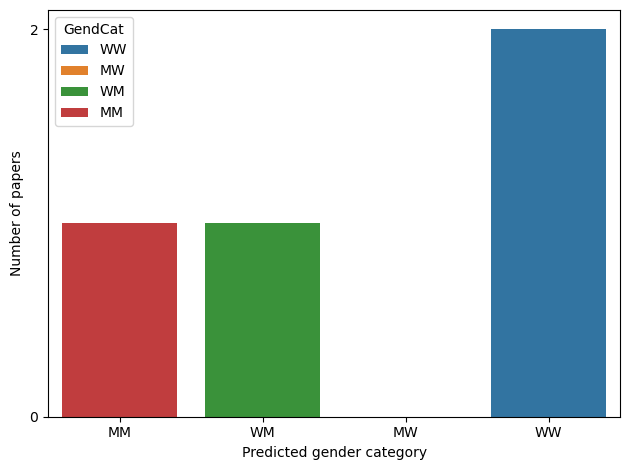

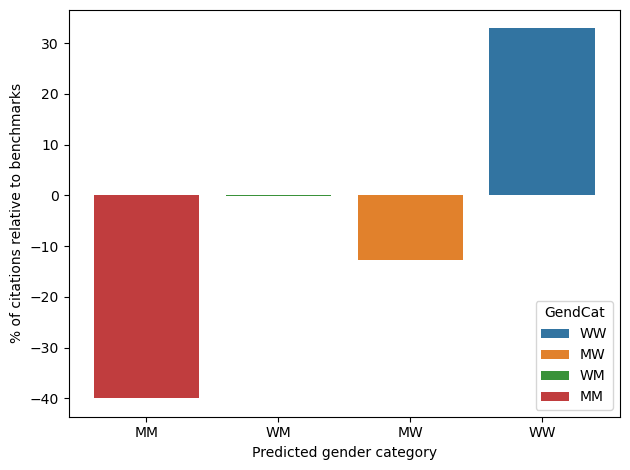

In [77]:
from matplotlib import ticker
for i in range(max(dat_for_baserate_plot['count']) + 1, 1):
    print(i)
# plot, sns is seaborn!
plt.figure()
ax = sns.barplot(data=dat_for_baserate_plot, x='GendCat', y='count', order=['MM','WM','MW','WW'], hue='GendCat', dodge = False)
plt.xlabel('Predicted gender category')
plt.ylabel('Number of papers')
#plt.yaxis.set_major_locator(ticker.MultipleLocator(2)) # left off here, trying to set y axis to integer breaks
ax.set_yticks(range(0, max(dat_for_baserate_plot['count']) + 1, 2))
ax.set_yticklabels(range(0, max(dat_for_baserate_plot['count']) + 1, 2))
plt.tight_layout()

plt.figure()
ax = sns.barplot(data=dat_for_baserate_plot, x='GendCat', y='citation_rel_to_baserate', order=['MM','WM','MW','WW'], hue='GendCat', dodge = False)
ax.hlines(y = 0, xmin = None, xmax = None, color = "black")
plt.xlabel('Predicted gender category')
plt.ylabel('% of citations relative to benchmarks')
plt.tight_layout()

In [ ]:



### TODO: repeat this for race/ethnicity!! nOT FIXED YET!!
# Create a data frame that will be used to plot the histogram. This will have the race category (e.g., WP, PP) in the first column and the percentage (e.g., number of WW citations divided by total number of citations * 100) in the second column #
dat_for_plot = names.groupby('RaceCat').size().reset_index()
all_cats = ['WU', 'PP', 'UW', 'WP', 'PW', 'UP', 'WW'] # could we not have UU?
empty_dat_for_plot = pd.DataFrame(0, index=np.arange(7), columns=['RaceCat', 0])
empty_dat_for_plot['RaceCat'] = all_cats
set(dat_for_plot['RaceCat']).intersection(empty_dat_for_plot['RaceCat'])
for i in set(dat_for_plot['RaceCat']).intersection(empty_dat_for_plot['RaceCat']):
    empty_dat_for_plot.loc[empty_dat_for_plot['RaceCat'] == i, 0] = dat_for_plot.loc[dat_for_plot['RaceCat']== i, 0].values
dat_for_plot = empty_dat_for_plot
dat_for_plot.rename(columns={0:'count'}, inplace=True)
dat_for_plot = dat_for_plot.assign(percentage=dat_for_plot['count']/total_citations*100)

# Create a data frame with only the WW, MW, WM, MM categories and their base rates - to plot percent citations relative to benchmarks
dat_for_baserate_plot = dat_for_plot.loc[(dat_for_plot.RaceCat == 'WW') |
                                         (dat_for_plot.RaceCat == 'PW') |
                                         (dat_for_plot.RaceCat == 'WP') |
                                         (dat_for_plot.RaceCat == 'PP'),:]
# except our rates for PoC are either author or both are POC, so how can we modify this?
# MM,MW,WM,WW
# 58.4% for man/man, 9.4% for man/woman, 25.5% for woman/man, and 6.7% for woman/woman
#baserate = [6.7, 9.4, 25.5, 58.4]
baserate = [0.74, 0.26] # base rates for IDD from JCT
dat_for_baserate_plot['baserate'] = baserate
dat_for_baserate_plot = dat_for_baserate_plot.assign(citation_rel_to_baserate=
                                                     dat_for_baserate_plot.percentage - dat_for_baserate_plot.baserate
                                                     )

# plot
plt.figure()
sns.barplot(data=dat_for_plot, x='GendCat', y='count', order=np.flip(gend_cats), hue='GendCat')
plt.xlabel('Predicted gender category')
plt.ylabel('Number of papers')
plt.tight_layout()

plt.figure()
sns.barplot(data=dat_for_baserate_plot, x='GendCat', y='citation_rel_to_baserate', order=['MM','WM','MW','WW'], hue='GendCat')
plt.xlabel('Predicted gender category')
plt.ylabel('% of citations relative to benchmarks')
plt.tight_layout()

